# PM2.5 Prophet Model - Data Analysis

PM2.5 forecasting with time series on Prophet

# 1. EDA
 (inspired by https://www.kaggle.com/code/alipakzad/bike-sharing-demand-regression-eda-visualization)

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [33]:


df = pd.read_csv("../data/pm25_enriched_hourly.csv")


print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

print("Missing values:", df.isnull().sum())

(9457112, 17)
           hex7_id                  timestamp  pm25_ugm3_mean        lat  \
0  872e0122effffff  2023-07-14 16:00:00+00:00             6.0  39.265577   
1  872e0122effffff  2023-07-21 19:00:00+00:00             5.0  39.265577   
2  872e0122effffff  2023-07-21 20:00:00+00:00             5.0  39.265577   
3  872e0122effffff  2023-07-21 21:00:00+00:00             5.0  39.265577   
4  872e0122effffff  2023-07-21 22:00:00+00:00             5.0  39.265577   

          lon nearest_traffic_hex  traffic_distance_km  has_local_traffic  \
0  141.845407     872e0120cffffff             3.899389              False   
1  141.845407     872e0120cffffff             3.899389              False   
2  141.845407     872e0120cffffff             3.899389              False   
3  141.845407     872e0120cffffff             3.899389              False   
4  141.845407     872e0120cffffff             3.899389              False   

  nearest_weather_hex  weather_distance_km  has_local_weather  \
0

/home/julia/.pyenv/versions/smoglens/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


       pm25_ugm3_mean           lat           lon  traffic_distance_km  \
count    7.617538e+06  9.457112e+06  9.457112e+06         9.457112e+06   
mean     8.998640e+00  3.547547e+01  1.366552e+02                  inf   
std      7.986715e+00  2.152189e+00  3.563470e+00                  NaN   
min      0.000000e+00  2.433914e+01  1.241592e+02         0.000000e+00   
25%      5.000000e+00  3.448255e+01  1.339611e+02         3.100417e+00   
50%      8.000000e+00  3.524958e+01  1.369161e+02         4.245349e+00   
75%      1.200000e+01  3.592415e+01  1.397188e+02         5.546214e+00   
max      4.170000e+03  4.511991e+01  1.443691e+02                  inf   

       weather_distance_km  avg_traffic_volume  temperature_c_mean  \
count         9.457112e+06        2.001834e+06       974342.000000   
mean          2.211406e+01        3.460727e+01           18.515088   
std           1.534853e+01        2.358469e+01           10.115916   
min           0.000000e+00        0.000000e+00       

In [35]:
df["timestamp"]= pd.to_datetime(df['timestamp'], utc=True)
df.set_index('timestamp', inplace=True)

# Stationarity & seasonality


In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [37]:
hex_id = '872e0122effffff'
df_hex = df[df['hex7_id'] == hex_id].copy()

/tmp/ipykernel_45771/2867144326.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df_hex['pm25_ugm3_mean'].resample('H').mean()


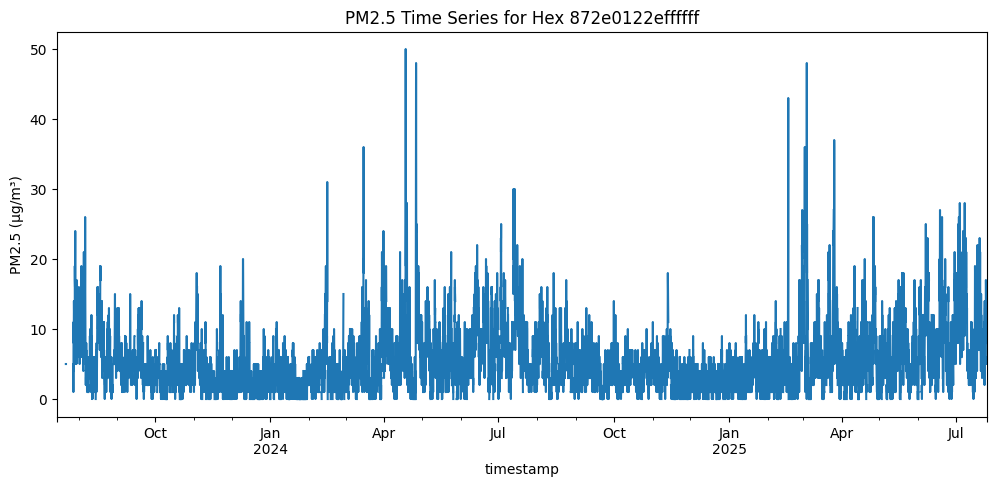

In [38]:
ts = df_hex['pm25_ugm3_mean'].resample('H').mean()

plt.figure(figsize=(12,5))
ts.plot(title=f"PM2.5 Time Series for Hex {hex_id}")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()


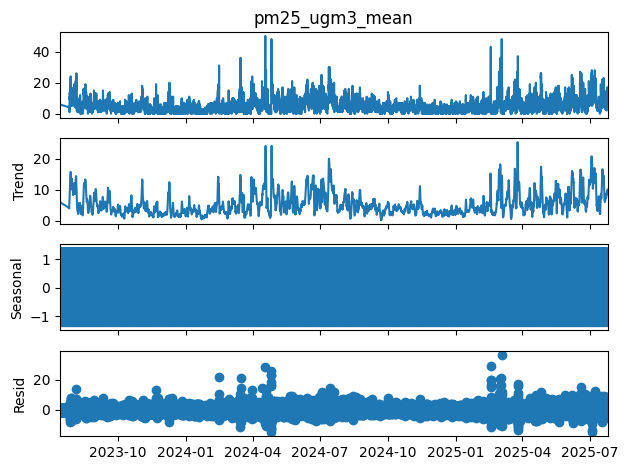

In [39]:
# Fill missing values (linear interpolation)
ts_clean = ts.interpolate(method='linear')

# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts_clean, model='additive', period=24)  # daily seasonality
decomp.plot()
plt.show()


In [40]:
# Stationarity check using Augmented Dickey-Fuller test
adf_result = adfuller(ts.dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] < 0.05:
    print("Series is likely stationary")
else:
    print("Series is likely non-stationary (differencing may be needed)")

ADF Statistic: -9.945908269874812
p-value: 2.5900606143101552e-17
Series is likely stationary


ADF Statistic: -9.946 → strongly negative, suggesting stationarity.

p-value: 2.59e-17 → far below 0.05, so we reject the null hypothesis of a unit root.

# Prophet Modelling